In [1]:
!nvidia-smi

Thu Feb  9 23:34:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.24       Driver Version: 528.24       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   41C    P3    12W /  35W |      0MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setup

We'll need [the Transformers library](https://huggingface.co/transformers/) by Hugging Face:

In [ ]:
!pip install -q -U watermark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 67.6 MB/s eta 0:00:00


In [ ]:
!pip install -qq transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 89.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 108.0 MB/s eta 0:00:00


In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.9.0

numpy       : 1.21.6
pandas      : 1.3.5
torch       : 1.13.1+cu116
transformers: 4.26.0



In [2]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cuda")

device

device(type='cuda', index=0)

## Data Exploration

We'll load the Google Play app reviews dataset, that we've put together in the previous part:

In [ ]:
# !gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
# !gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

In [17]:
#df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dati/extended-data-copy-1.csv")
#df = pd.read_csv("extended-data.csv")
df = pd.read_csv("./italian_reviews/betsentiment-IT-tweets-sentiment-players.csv",encoding='cp1252' )

df.head()

,tweet_date_created,tweet_id,tweet_text,language,sentiment,sentiment_score
0,2018-12-10T10:45:40.865000,1072079899224100865,"@juventusfc @G_Higuain Auguri pipita,sempre co...",it,NEUTRAL,"{""Neutral"":0.858726024627685546875,""Negative"":..."
1,2018-06-30T18:41:02.817000,1013130303454498817,@realvarriale @massimozampini @KMbappe @G_Higu...,it,NEUTRAL,"{""Neutral"":0.973993778228759765625,""Negative"":..."
2,2018-12-26T19:40:44.308000,1078012758069858308,@OfficialASRoma @D_10Perotti @Hyundai_Italia S...,it,NEUTRAL,"{""Neutral"":0.9844334125518798828125,""Negative""..."
3,2018-07-12T11:26:37.766000,1017369635816181766,@CarloRienzi @Cristiano @juventusfc Populismo ...,it,NEUTRAL,"{""Neutral"":0.993849217891693115234375,""Negativ..."
4,2018-06-12T19:20:36,1006617282779451392,@OfficialASRoma @OfficialRadja @leonsfdo non c...,it,NEUTRAL,"{""Neutral"":0.87245881557464599609375,""Negative..."


In [18]:
df.shape

(165815, 6)

We have about 16k examples. Let's check for missing values:

In [11]:
df=pd.concat([df]*2, ignore_index=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293820 entries, 0 to 293819
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   company_name  293820 non-null  int64 
 1   review_title  293820 non-null  object
 2   review_text   293820 non-null  object
 3   review_stars  293820 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 9.0+ MB


Great, no missing values in the score and review texts! Do we have class imbalance?

In [25]:
# Create a new dataframe with two columns
train_raw = df[['sentiment', 'tweet_text']].copy()

# Remove missing values (NaN)
train_raw = train_raw[pd.notnull(train_raw['tweet_text'])]

# Renaming second column for a simpler name
# train_raw.columns = ['years', 'consumer_complaint_narrative']

In [26]:
train_raw = train_raw[train_raw.tweet_text.notnull()]

train_raw['len_txt'] =train_raw.tweet_text.apply(lambda x: len(x.split()))
train_raw.describe()

,len_txt
count,165815.000000
mean,18.492844
std,11.793992
min,1.000000
25%,10.000000
50%,15.000000
75%,24.000000
max,82.000000


In [24]:
#train_raw = train_raw[train_raw.len_txt >249]
#train_raw.describe()

In [27]:
train_raw = train_raw[['tweet_text', 'sentiment']]
train_raw.reset_index(inplace=True, drop=True)

# train_raw["years"] = pd.to_datetime(train_raw["Date_received"]).dt.strftime('%Y')
train_raw.head(1)

,tweet_text,sentiment
0,"@juventusfc @G_Higuain Auguri pipita,sempre co...",NEUTRAL


In [ ]:
# train_raw['consumer_complaint_narrative'] = train_raw['consumer_complaint_narrative'].str.replace("2015", "")
# train_raw['consumer_complaint_narrative'] = train_raw['consumer_complaint_narrative'].str.replace("2016", "")
# train_raw['consumer_complaint_narrative'] = train_raw['consumer_complaint_narrative'].str.replace("2017", "")
# train_raw['consumer_complaint_narrative'] = train_raw['consumer_complaint_narrative'].str.replace("2018", "")
# train_raw['consumer_complaint_narrative'] = train_raw['consumer_complaint_narrative'].str.replace("2019", "")
#
# train_raw['consumer_complaint_narrative'] = train_raw['consumer_complaint_narrative'].str.replace("15", "")
# train_raw['consumer_complaint_narrative'] = train_raw['consumer_complaint_narrative'].str.replace("17", "")
# train_raw['consumer_complaint_narrative'] = train_raw['consumer_complaint_narrative'].str.replace("18", "")
# train_raw['consumer_complaint_narrative'] = train_raw['consumer_complaint_narrative'].str.replace("19", "")
# train_raw['consumer_complaint_narrative'] = train_raw['consumer_complaint_narrative'].str.replace("16", "")
#
# train_raw['consumer_complaint_narrative'] = train_raw['consumer_complaint_narrative'].str.replace("xx", "")
# train_raw['consumer_complaint_narrative'] = train_raw['consumer_complaint_narrative'].str.replace("XX", "")
# train_raw['consumer_complaint_narrative'] = train_raw['consumer_complaint_narrative'].str.replace("XXXX", "")
# train_raw['consumer_complaint_narrative'] = train_raw['consumer_complaint_narrative'].str.replace("//", "")
# train_raw['consumer_complaint_narrative'] = train_raw['consumer_complaint_narrative'].str.replace("/", "")

In [28]:
df2 = train_raw.copy()

In [29]:
df2 = df2.reindex(np.random.permutation(df2.index))

In [32]:
import re

In [33]:
def clean_txt(text):
   text = re.sub("'", "",text)
   text=re.sub("(\\W)+"," ",text)
   return text

In [34]:
df2['tweet_text']  = df2.tweet_text.apply(clean_txt)
df2.head(1)

,tweet_text,sentiment
107363,SimoneZaza cuore bianconero ToroJuve FinoAlla...,NEUTRAL


In [35]:
df2.reset_index(drop=True, inplace=True)
df2.head(1)

,tweet_text,sentiment
0,SimoneZaza cuore bianconero ToroJuve FinoAlla...,NEUTRAL


In [36]:
df2=df2.rename(columns = {'tweet_text':'text'})
df2.head(1)

,text,sentiment
0,SimoneZaza cuore bianconero ToroJuve FinoAlla...,NEUTRAL


In [37]:
df2=df2.rename(columns = {'text':'comment'})
df2.head()

,comment,sentiment
0,SimoneZaza cuore bianconero ToroJuve FinoAlla...,NEUTRAL
1,come sia possibile tenere in panchina douglasc...,NEUTRAL
2,Dopo la sconfitta contro il BEL ci sta una bel...,POSITIVE
3,FCBayernUS gianluigibuffon Manuel_Neuer O ma ...,NEUTRAL
4,NOIconVOI gli auguri del gallobelotti bomber ...,NEUTRAL


In [38]:
df3 = df2.sample(10000, random_state=1).copy()

In [39]:
#dfreviews = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dati/extended-data-copy-1.csv")

#dfreviews.head()

In [40]:
from importlib.metadata import version
version('seaborn')

'0.11.2'

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


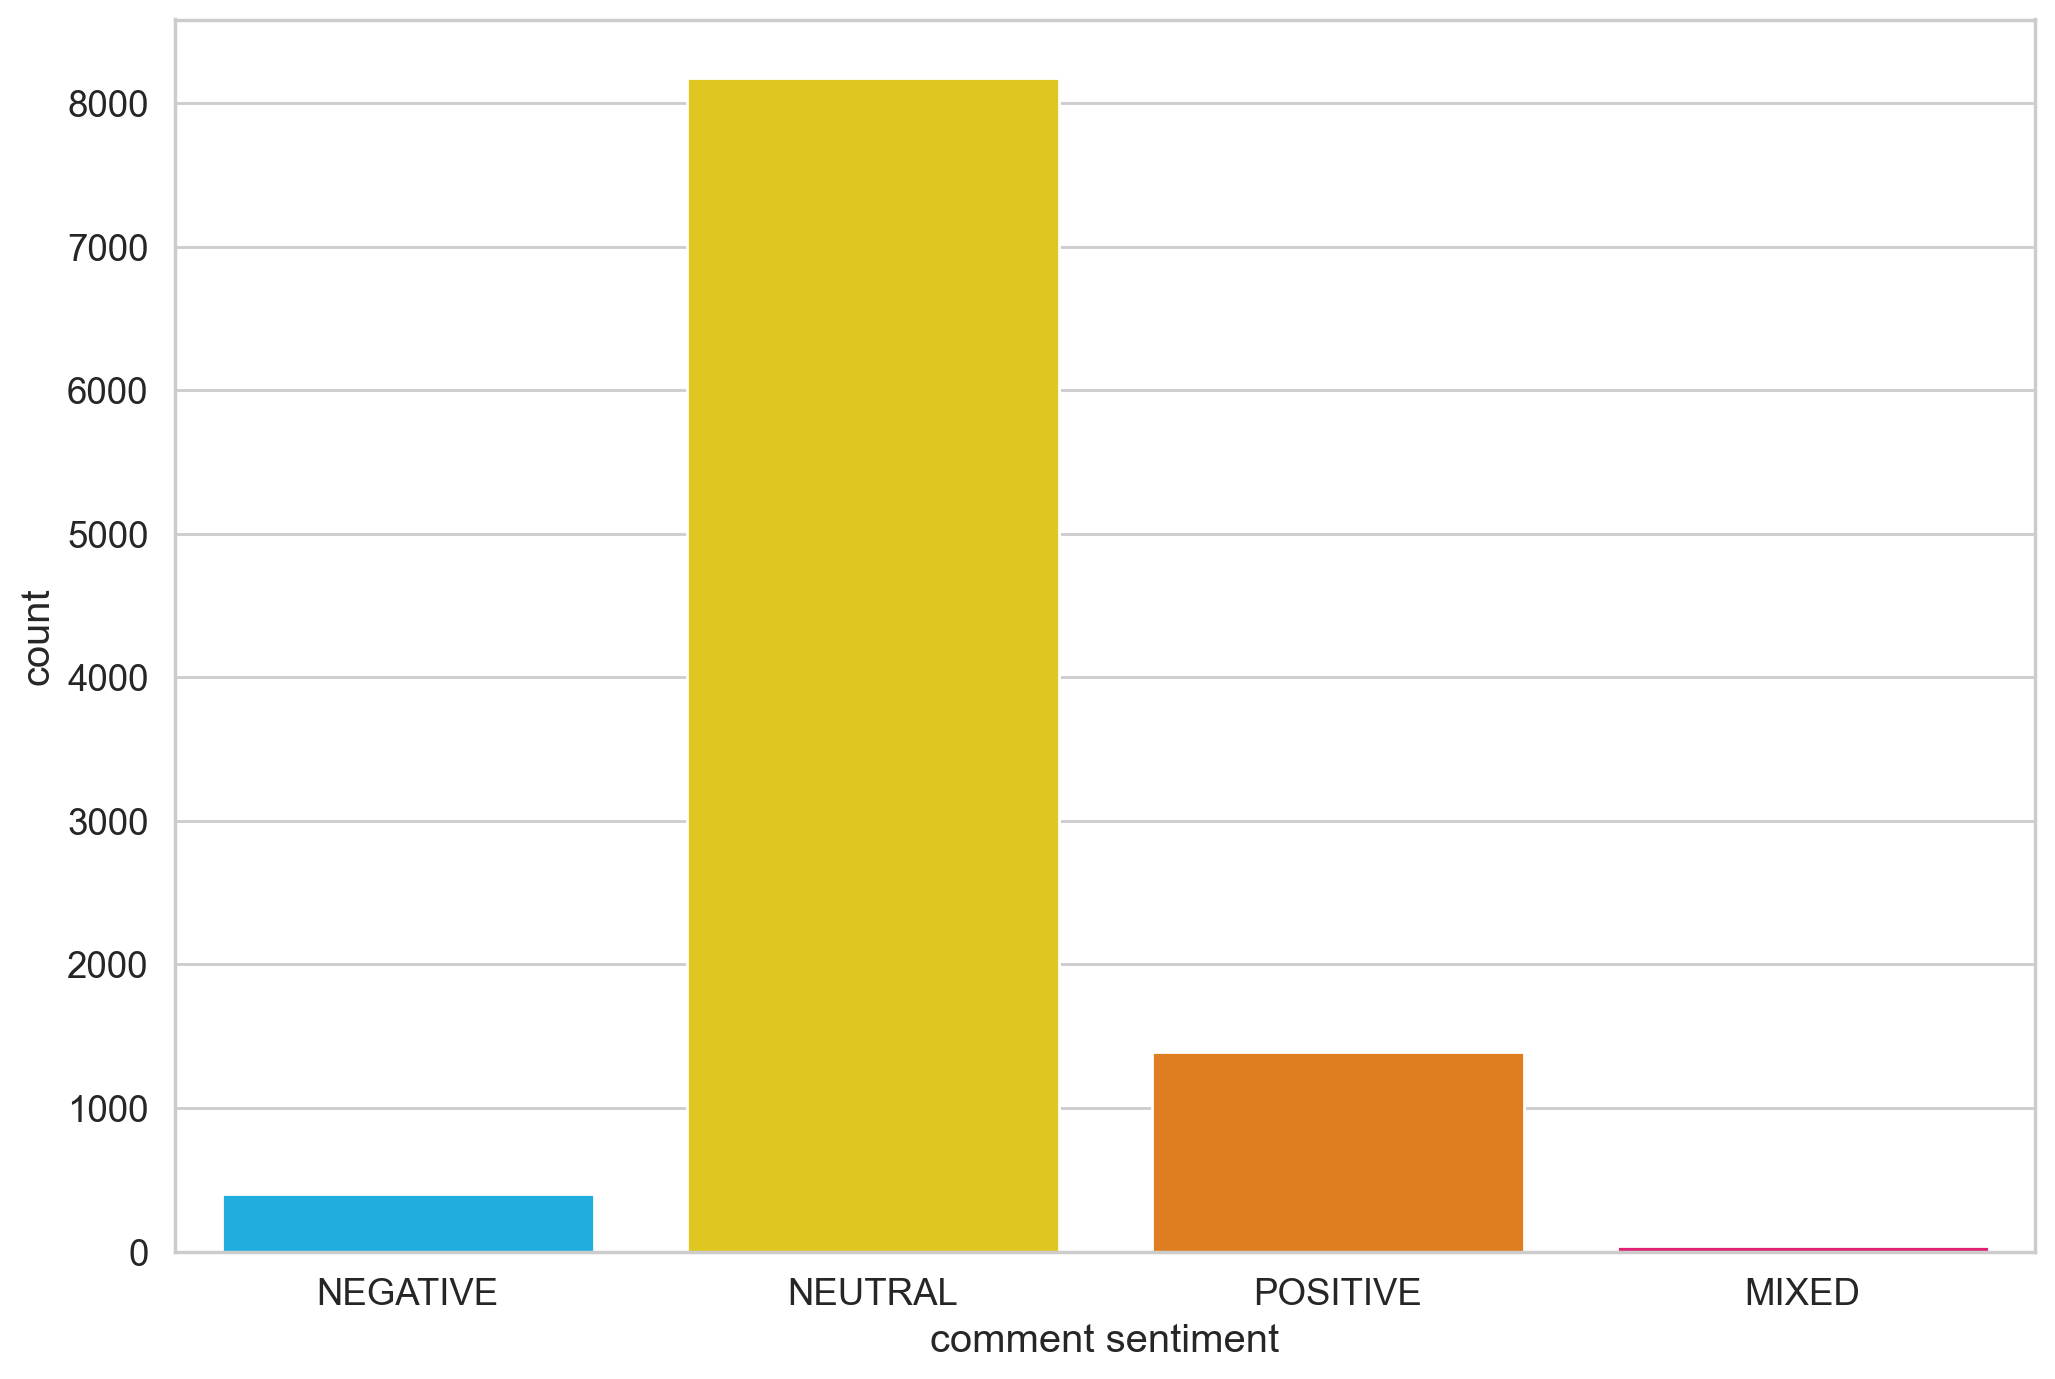

In [42]:
sns.countplot(df3.sentiment)
plt.xlabel('comment sentiment');

That's hugely imbalanced, but it's okay. We're going to convert the dataset into negative, neutral and positive sentiment:

In [ ]:
#df4 = df3.copy()
#def to_sentiment(rating):
#   rating = int(rating)
#   if rating <= 2:
#     return 0
#   elif rating == 3:
#     return 1
#   else: 
#     return 2

#df4['sentiment'] = df4.score.apply(to_sentiment)

In [48]:
class_names = ['NEGATIVE', 'NEUTRAL', 'POSITIVE', 'MIXED']

In [49]:
possible_labels = df3.sentiment.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'NEGATIVE': 0, 'NEUTRAL': 1, 'POSITIVE': 2, 'MIXED': 3}

In [50]:
class_names=list(label_dict.keys())
# class_names = ['2017', '2016', '2018', '2019', '2015']
class_names

['NEGATIVE', 'NEUTRAL', 'POSITIVE', 'MIXED']

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


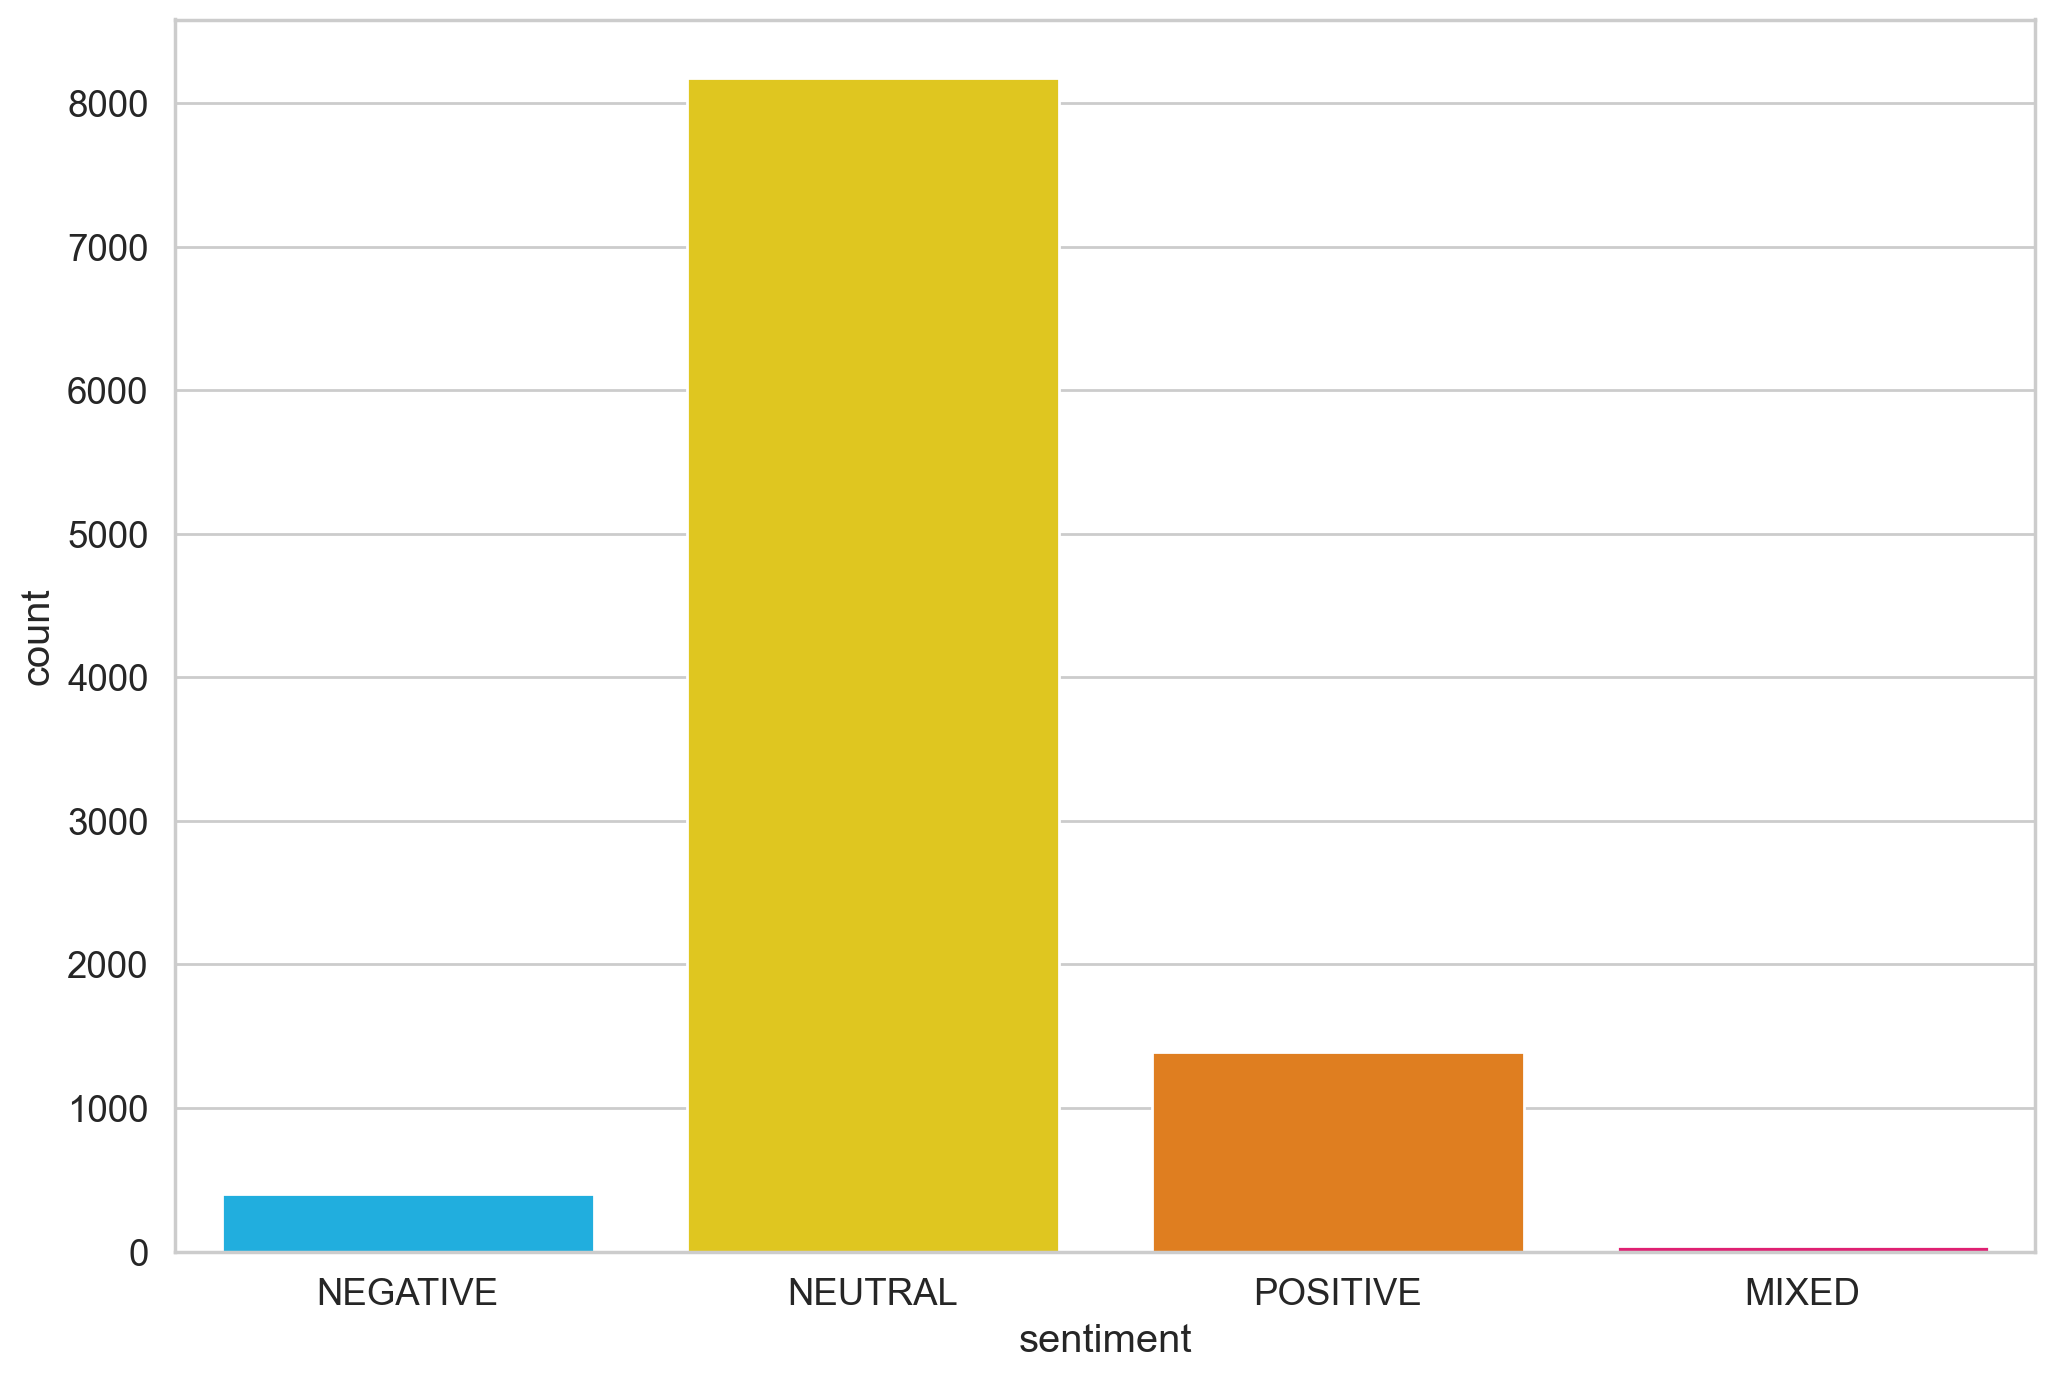

In [53]:
ax = sns.countplot(df3.sentiment)
plt.xlabel('sentiment')
ax.set_xticklabels(class_names);

The balance was (mostly) restored. !!!!!!!!!!!!?????????????

In [54]:
df3['label'] = df3.sentiment.replace(label_dict)
df3.head(1)

,comment,sentiment,label
83282,ilRomanistaweb OfficialRadja A Radja Martinez...,NEGATIVE,0


In [55]:
# df3 = df2.sample(7000, random_state=1).copy()
df4 = df3.copy()

In [ ]:
# df3.head(2)

In [56]:
# df3.reset_index(drop=True, inplace=True)
df4.head(3)

,comment,sentiment,label
83282,ilRomanistaweb OfficialRadja A Radja Martinez...,NEGATIVE,0
35579,realvarriale Cristiano Anche stuprare è da ca...,NEUTRAL,1
118640,belgio la nazionale ai mondiali più forte che...,NEUTRAL,1


## Data Preprocessing

You might already know that Machine Learning models don't work with raw text. You need to convert text to numbers (of some sort). BERT requires even more attention (good one, right?). Here are the requirements: 

- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (introduce padding)
- Create array of 0s (pad token) and 1s (real token) called *attention mask*

The Transformers library provides (you've guessed it) a wide variety of Transformer models (including BERT). It works with TensorFlow and PyTorch! It also includes prebuild tokenizers that do the heavy lifting for us!


In [57]:
#PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
PRE_TRAINED_MODEL_NAME = 'dbmdz/bert-base-italian-cased'

> You can use a cased and uncased version of BERT and tokenizer. I've experimented with both. The cased version works better. Intuitively, that makes sense, since "BAD" might convey more sentiment than "bad".

Let's load a pre-trained [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

In [58]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

We'll use this text to understand the tokenization process:

In [59]:
sample_txt = 'molto bene PC.'

Some basic operations can convert the text to tokens and tokens to unique integers (ids):

In [60]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: molto bene PC.
   Tokens: ['molto', 'bene', 'PC', '.']
Token IDs: [617, 543, 6402, 697]


### Special Tokens

`[SEP]` - marker for ending of a sentence


In [61]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 103)

`[CLS]` - we must add this token to the start of each sentence, so BERT knows we're doing classification

In [62]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 102)

There is also a special token for padding:

In [63]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

BERT understands tokens that were in the training set. Everything else can be encoded using the `[UNK]` (unknown) token:

In [64]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 101)

All of that work can be done using the [`encode_plus()`](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.encode_plus) method:

In [65]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=256,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\ProgramData\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['input_ids', 'attention_mask'])

The token ids are now stored in a Tensor and padded to a length of 32:

In [66]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

256


tensor([ 102,  617,  543, 6402,  697,  103,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   

The attention mask has the same length:

In [67]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

256


tensor([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

We can inverse the tokenization to have a look at the special tokens:

In [68]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'molto',
 'bene',
 'PC',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]'

### Choosing Sequence Length

BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length. Let's store the token length of each review:

In [69]:
token_lens = []

for txt in df4.comment:
  tokens = tokenizer.encode(txt, max_length=260)
  token_lens.append(len(tokens))

and plot the distribution:

In [ ]:
# sns.distplot(token_lens)
# plt.xlim([0, 256]);
# plt.xlabel('Token count');

Most of the reviews seem to contain less than 128 tokens, but we'll be on the safe side and choose a maximum length of 160.

In [70]:
MAX_LEN = 256

We have all building blocks required to create a PyTorch dataset. Let's do it:

In [76]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': reviews,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it'll be easier to evaluate the predictions from our model. Let's split the data:

In [77]:
df_train, df_test = train_test_split(df4, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [78]:
df_train.shape, df_val.shape, df_test.shape

((9000, 3), (500, 3), (500, 3))

We also need to create a couple of data loaders. Here's a helper function to do it:

In [79]:
def create_data_loader(df4, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df3.comment.to_numpy(),
    targets=df3.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [80]:
BATCH_SIZE = 4

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Let's have a look at an example batch from our training data loader:

In [81]:
data = next(iter(train_data_loader))
data.keys()

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([4, 256])
torch.Size([4, 256])
torch.Size([4])


## Sentiment Classification with BERT and Hugging Face

There are a lot of helpers that make using BERT easy with the Transformers library. Depending on the task you might want to use [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification), [BertForQuestionAnswering](https://huggingface.co/transformers/model_doc/bert.html#bertforquestionanswering) or something else. 

But who cares, right? We're *hardcore*! We'll use the basic [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and build our sentiment classifier on top of it. Let's load the model:

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


And try to use it on the encoding of our sample text:

In [ ]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask'],
  return_dict = False
)

The `last_hidden_state` is a sequence of hidden states of the last layer of the model. Obtaining the `pooled_output` is done by applying the [BertPooler](https://github.com/huggingface/transformers/blob/edf0582c0be87b60f94f41c659ea779876efc7be/src/transformers/modeling_bert.py#L426) on `last_hidden_state`:

In [ ]:
last_hidden_state.shape

torch.Size([1, 256, 768])

We have the hidden state for each of our 32 tokens (the length of our example sequence). But why 768? This is the number of hidden units in the feedforward-networks. We can verify that by checking the config:

In [ ]:
bert_model.config.hidden_size

768



You can think of the `pooled_output` as a summary of the content, according to BERT. Albeit, you might try and do better. Let's look at the shape of the output:

In [ ]:
pooled_output.shape

torch.Size([1, 768])

We can use all of this knowledge to create a classifier that uses the BERT model:

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict = False
    )
    output = self.drop(pooled_output)
    return self.out(output)

Our classifier delegates most of the heavy lifting to the BertModel. We use a dropout layer for some regularization and a fully-connected layer for our output. Note that we're returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

This should work like any other PyTorch model. Let's create an instance and move it to the GPU:

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


We'll move the example batch of our training data to the GPU:

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([4, 256])
torch.Size([4, 256])


To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:

In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.0174, 0.0321, 0.0290, 0.0572, 0.0337, 0.0389, 0.0275, 0.0521, 0.0476,
         0.0357, 0.0299, 0.0808, 0.0299, 0.0500, 0.0369, 0.0328, 0.0395, 0.0249,
         0.0139, 0.0347, 0.0495, 0.0366, 0.0644, 0.0523, 0.0207, 0.0323],
        [0.0216, 0.0395, 0.0371, 0.0728, 0.0264, 0.0277, 0.0294, 0.0283, 0.0329,
         0.1009, 0.0333, 0.0659, 0.0687, 0.0385, 0.0382, 0.0629, 0.0198, 0.0261,
         0.0341, 0.0286, 0.0278, 0.0252, 0.0319, 0.0444, 0.0130, 0.0251],
        [0.0276, 0.0241, 0.0339, 0.0833, 0.0275, 0.0230, 0.0528, 0.0433, 0.0799,
         0.0348, 0.0491, 0.0656, 0.0413, 0.0271, 0.0394, 0.0277, 0.0191, 0.0172,
         0.0311, 0.0280, 0.0461, 0.0255, 0.0499, 0.0523, 0.0188, 0.0315],
        [0.0094, 0.0205, 0.0168, 0.0941, 0.0321, 0.0237, 0.0286, 0.0299, 0.0370,
         0.0671, 0.0168, 0.0860, 0.0200, 0.0318, 0.0693, 0.0473, 0.0197, 0.0248,
         0.0340, 0.0469, 0.0587, 0.0230, 0.0352, 0.0676, 0.0125, 0.0473]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)

### Training

To reproduce the training procedure from the BERT paper, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps:

In [ ]:
EPOCHS = 4

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


How do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

We're going to ignore the number of epochs recommendation but stick with the rest. Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.

Let's continue with writing a helper function for training our model for one epoch:

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

Training the model should look familiar, except for two things. The scheduler gets called every time a batch is fed to the model. We're avoiding exploding gradients by clipping the gradients of the model using [clip_grad_norm_](https://pytorch.org/docs/stable/nn.html#clip-grad-norm).

Let's write another one that helps us evaluate the model on a given data loader:

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Using those two, we can write our training loop. We'll also store the training history:

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/4
----------
Train loss 3.154260789079869 accuracy 0.09366684406599254
Val   loss 2.397535035243401 accuracy 0.375

Epoch 2/4
----------
Train loss 1.0904747606116407 accuracy 0.768493879723257
Val   loss 0.18660837268600097 accuracy 1.0

Epoch 3/4
----------
Train loss 0.07592831105390127 accuracy 0.9994678020223523
Val   loss 0.017240785384693973 accuracy 1.0

Epoch 4/4
----------
Train loss 0.0214173765357663 accuracy 0.9999999999999999
Val   loss 0.011714732310233207 accuracy 1.0

CPU times: user 4min 29s, sys: 1min 49s, total: 6min 18s
Wall time: 6min 46s


Note that we're storing the state of the best model, indicated by the highest validation accuracy.

Whoo, this took some time! We can look at the training vs validation accuracy:

TypeError: ignored

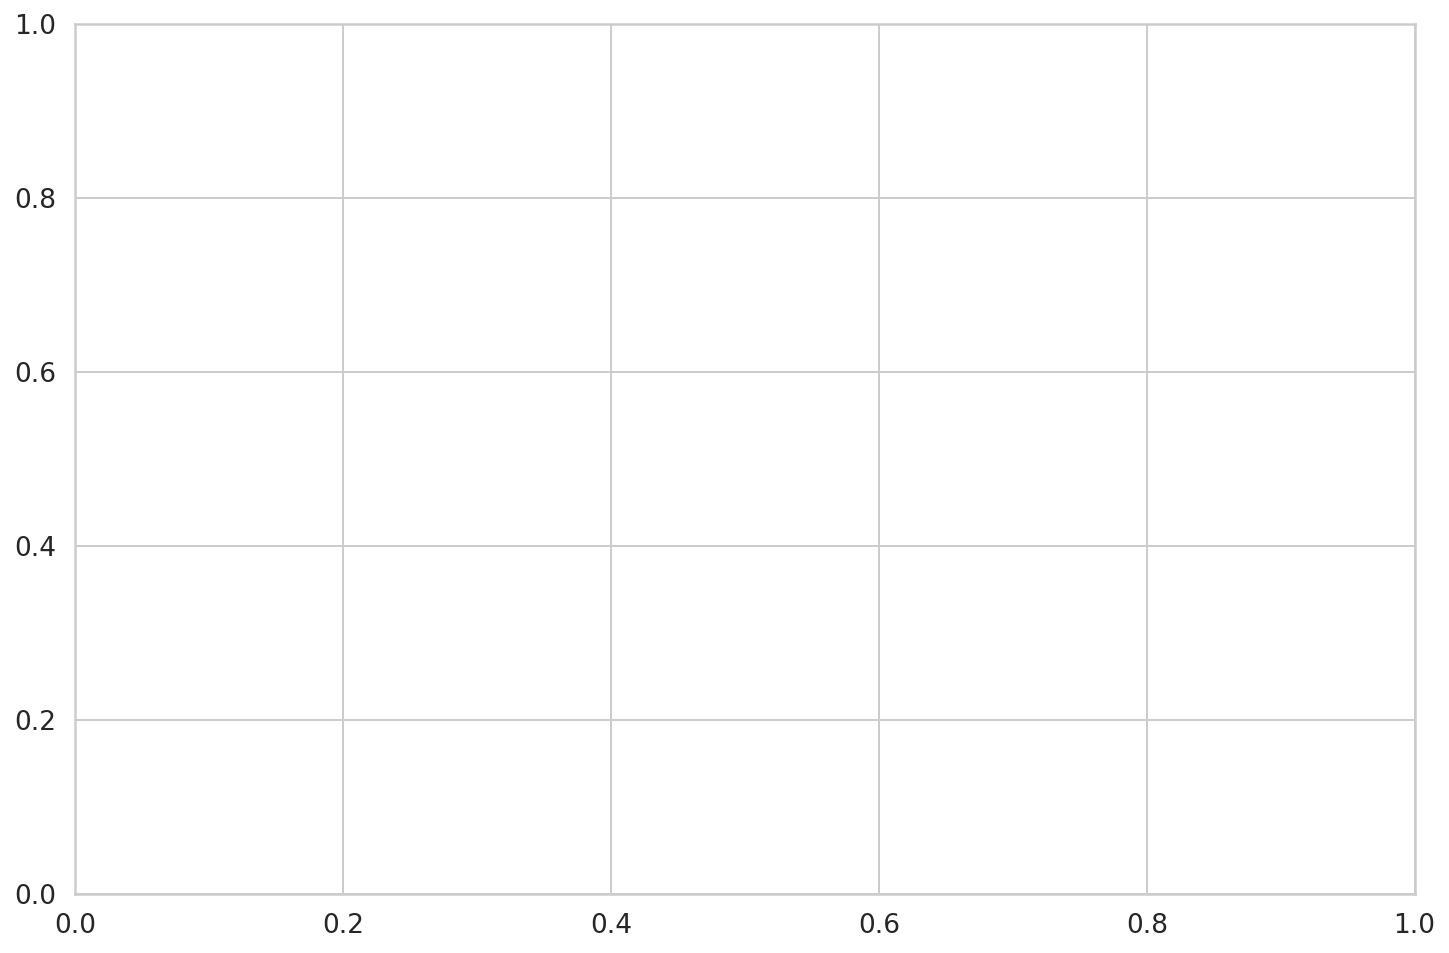

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

The training accuracy starts to approach 100% after 10 epochs or so. You might try to fine-tune the parameters a bit more, but this will be good enough for us.

Don't want to wait? Uncomment the next cell to download my pre-trained model:

In [ ]:
# # !gdown --id 1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA

# model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/dati/Models/best_model_state.bin'))
#model.load_state_dict(torch.load('./data_volume/finetuned_BERT_epoch_1.model'))
model = model.to(device)

RuntimeError: ignored

## Evaluation

So how good is our model on predicting sentiment? Let's start by calculating the accuracy on the test data:

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(

0.0380952380952381

The accuracy is about 1% lower on the test set. Our model seems to generalize well.

We'll define a helper function to get the predictions from our model:

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Let's have a look at the classification report

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

        1451       0.00      0.00      0.00         3
        1449       0.00      0.00      0.00         3
        1480       0.14      0.67      0.24         3
        1453       0.00      0.00      0.00         2
        1462       0.00      0.00      0.00         5
        1468       0.03      0.33      0.05         3
        1481       0.00      0.00      0.00         7
        1476       0.00      0.00      0.00         2
   1444-1448       0.00      0.00      0.00         4
        1493       0.00      0.00      0.00         4
   1463-1467       0.00      0.00      0.00         7
        1489       0.00      0.00      0.00         1
        1448       0.00      0.00      0.00         5
        1446       0.00      0.00      0.00         3
   1480-1485       0.00      0.00      0.00         6
        1458       0.03      0.50      0.05         2
        1460       0.00      0.00      0.00         2
        1456       0.00    

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Looks like it is really hard to classify neutral (3 stars) reviews. And I can tell you from experience, looking at many reviews, those are hard to classify.

We'll continue with the confusion matrix:

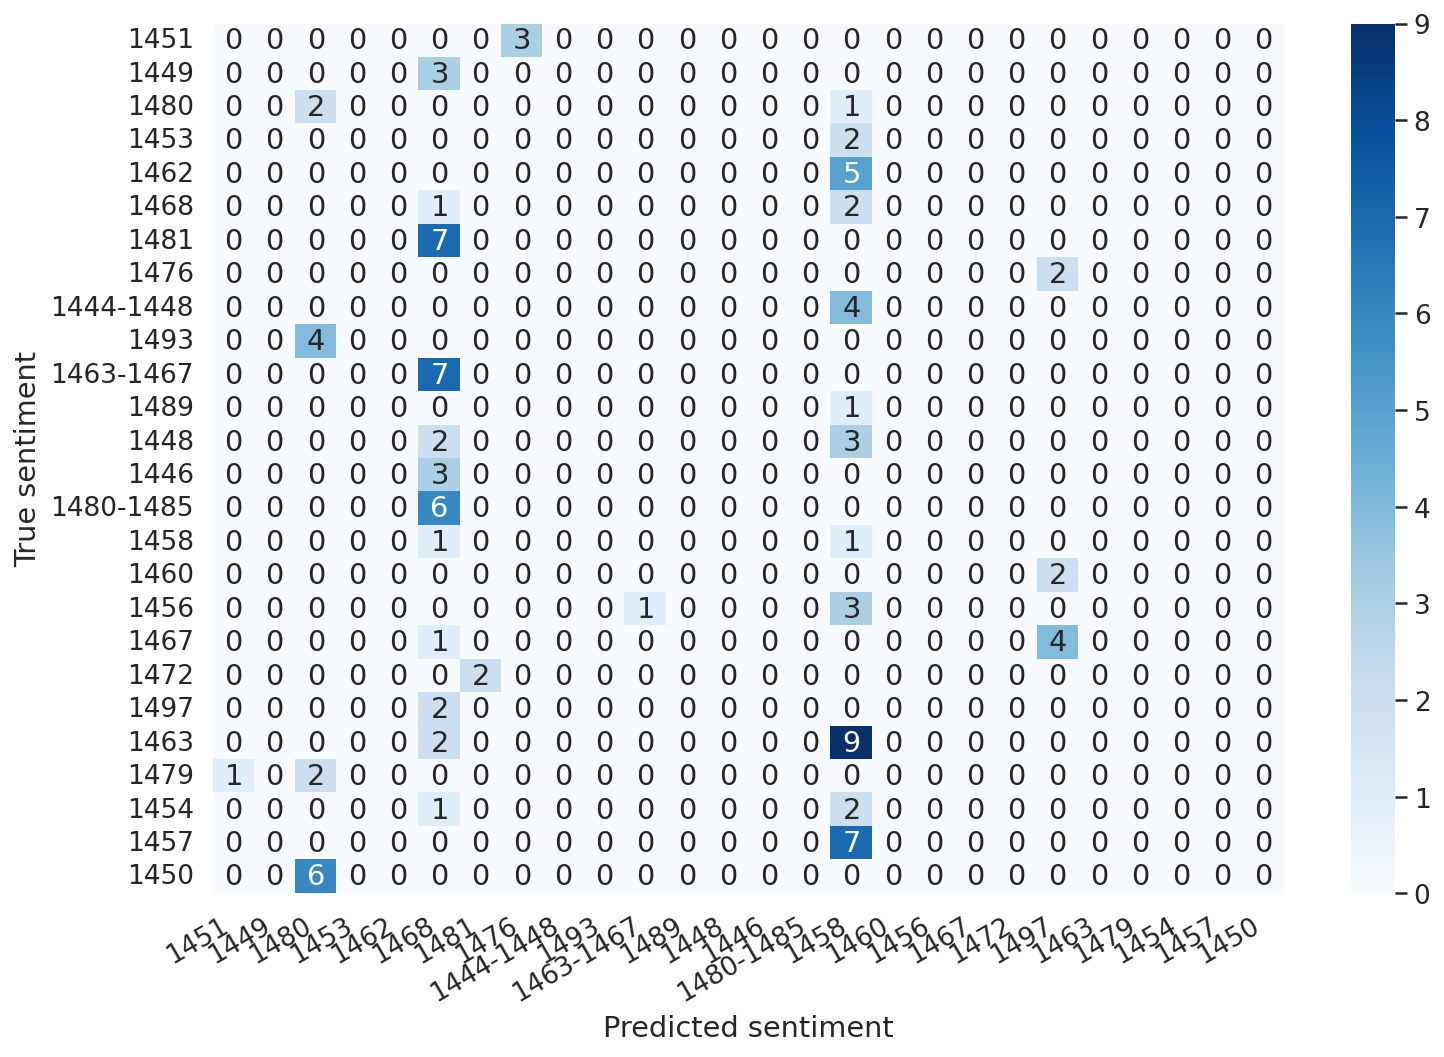

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True date')
  plt.xlabel('Predicted date');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

This confirms that our model is having difficulty classifying neutral reviews. It mistakes those for negative and positive at a roughly equal frequency.

That's a good overview of the performance of our model. But let's have a look at an example from our test data:

In [ ]:
idx = 2

review_text = y_review_texts[idx]
true_date = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True date: {class_names[true_date]}')

Poiché ne' giorni passati ti scripsi del gran fragello d'uno
spaventevole et inusitato tremuoto, che sabato a dì 4 di questo, di
nocte, in su 11 hore, apparì in gran parte di questo paese, con tanti
danni di rovine di case, di palagi, di chiese, di sobissamento di
terre, di castella et di città, et con grandissima occisione
d'huomini, ricevetti la tua con la 'nformatione de' gesti del nostro
messer Giannozo Pandolfini. Et inteso la voglia tua et la richiesta mi
fai dello scrivere oratione funebre, ti lodo et commendo della
singulare affectione portasti a' costumi et alle virtù sue. Et
perch'io mi trovo in simil grado d'affectione, sono contento pigliarne
la faticha dello scrivere, sì per sodisfare al debito della affectione
gli portavo, sì anchora per compiacerne a te, considerando la maniera
della richiesta me ne fai. Et però ho avuta chara la informatione
mandatami. Ma perché sono cose da scriverle con qualche dignità,
altrimenti farebbono il contrario effecto al disegno se ne fa, vo

Now we can look at the confidence of each sentiment of our model:

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('years')
plt.xlabel('probability')
plt.xlim([0, 1]);

NameError: ignored

### Predicting on Raw Text

Let's use our model to predict the year of some raw text:

In [ ]:
review_text = "Quamquam impresentiarum nihil haberem quod ad te scriberem, tecum tamen litterarum silentio uti non potui, ne forte secundum Aristotelis sententiam taciturnitatis diuturnitas utriusque nostrum amicitiam dirimeret. Multas enim amicitias silentium dirimere vetus memorati Philisophi sententia est. Quid igitur ad te scribam, nihil habens quod scribam? Hoc solum scripsero, quod in huius epistolae meae calce idcirco de industria apposui, ne tu pluribus aliis rebus intentus memoriam mei absentis negligeres atque propterea oblivioni traderes. Itaque, suavissime Vespasiane, quaeso, mei memor esto, sicut ego tui memor sum."


We have to use the tokenizer to encode the text:

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Let's get the predictions from our model:

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'predicted year: {class_names[prediction]}')

Review text: Quamquam impresentiarum nihil haberem quod ad te scriberem, tecum tamen litterarum silentio uti non potui, ne forte secundum Aristotelis sententiam taciturnitatis diuturnitas utriusque nostrum amicitiam dirimeret. Multas enim amicitias silentium dirimere vetus memorati Philisophi sententia est. Quid igitur ad te scribam, nihil habens quod scribam? Hoc solum scripsero, quod in huius epistolae meae calce idcirco de industria apposui, ne tu pluribus aliis rebus intentus memoriam mei absentis negligeres atque propterea oblivioni traderes. Itaque, suavissime Vespasiane, quaeso, mei memor esto, sicut ego tui memor sum.
predicted year: 1444-1448


## References

- [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)
- [L11 Language Models - Alec Radford (OpenAI)](https://www.youtube.com/watch?v=BnpB3GrpsfM)
- [The Illustrated BERT, ELMo, and co.](https://jalammar.github.io/illustrated-bert/)
- [BERT Fine-Tuning Tutorial with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)
- [How to Fine-Tune BERT for Text Classification?](https://arxiv.org/pdf/1905.05583.pdf)
- [Huggingface Transformers](https://huggingface.co/transformers/)
- [BERT Explained: State of the art language model for NLP](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)